In [460]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
import time

fmin = 311.25*10**6 #Hz
fban = 16*10**6 #Hz
freq = fmin + 0 * fban
fsample = 2*fban
Period = 1.6*10**(-3) #seconds
PulseWidth = Period/200
R = 6.273 #s
intime = 32/8000
insample = 8000/32

fref = fmin#Hz

FileName = "data/test2_caustic_"

# This generates the signal time series. It's some gaussian envelope * random values between +-0.5
def Signal(width=PulseWidth*fsample, length=int(Period*fsample), Noise=0):
    s = np.random.rand(length)-0.5
    t = np.array(range(length))
    t0 = length/2
    envelop = np.exp( -((t-t0)/width)**2 )
    return envelop*s

def PhaseArray(SignalBand, GeoPath, DisPath, Freq):
    LG = len(GeoPath)
    LD = len(DisPath)
    if LG > LD:
        DisPath = np.pad(DisPath,int((LG-LD)/2)+1,'edge')
        DisPath = DisPath[:LG]
    w = Freq + np.array(range(SignalBand))*fban/SignalBand # frequency array, of size fourier transform of signal
    PA = np.outer(w,GeoPath) - np.outer(((fref**2)/w),DisPath)  # the "phase array". it consist of a vertical array of frequencies, each of which has some paths associated.
    return PA

def PhaseFactor(PV):
    phase = np.exp(2*np.pi*(0+1j)*PV )
    return phase

def PathInt(PA): # semi-analytical
    PathInt = []
    fRange, pathRange = np.shape(PA)
    for i in range(fRange):
        Onef = 0
        IntRange, weight = FindIntRange(PA[i,:])
        for j in IntRange:
            Onef += weight[j] * PhaseFactor(PA[i,j])
        PathInt += [Onef]
    return np.array(PathInt)

def FindIntRange(TotPath):
    width = 0.289
    dPath = np.gradient(TotPath)
    window = np.exp(-dPath**2/(2*(width)**2))
    IntRange = np.where(window > 3e-3)[0]
    return IntRange, window

def Scan(begin, end, freq):
    scan = range(begin,end)
    res = np.linspace(-1/2,1/2,10,endpoint='true')[:-1]
    lensed = []
    spec = []
    for i in scan:
        dp = dispath[i-(dens*500):i+(dens*500+1)]
        for j in res:
            gp = GeoPath(j)
            PA = PhaseArray(l,gp,dp,freq)
            PI = PathInt(PA)
            s1 = np.fft.irfft(sf*PI)
            # save intensity as well as spectrum
            lensed += [(s1**2).sum()]
            spec += [sf*PI]
        print freq/10**6, i, begin, end, time.clock()
    return np.array(lensed)/norm, np.array(spec)

def DisPath():
    x = np.random.rand(20)*2-1
    y = np.random.rand(20)*2-1
    z = (1+0j)*x + (0+1j)*y
    q = np.array([0]*1981)
    z = np.concatenate((z,q))
    z = np.fft.irfft(z)
    amp = 4*10**(-6)
    z = z*amp/np.max(np.abs(z))
    return z

In [461]:
#%cd /home/flin/scr/binary-lens
%cd ~/Dropbox/Research/binary-lens

/Users/fx/Dropbox/Research/binary-lens


In [462]:
%matplotlib notebook

In [465]:
dispath = DisPath() #np.load('data/test2Dis.npy')
dens = 4
temp = np.fft.rfft(dispath)
temp = np.concatenate((temp,np.zeros( (dens-1)*2000 )))
temp = np.fft.irfft(temp)
temp *= dens
dispath = temp

<IPython.core.display.Javascript object>


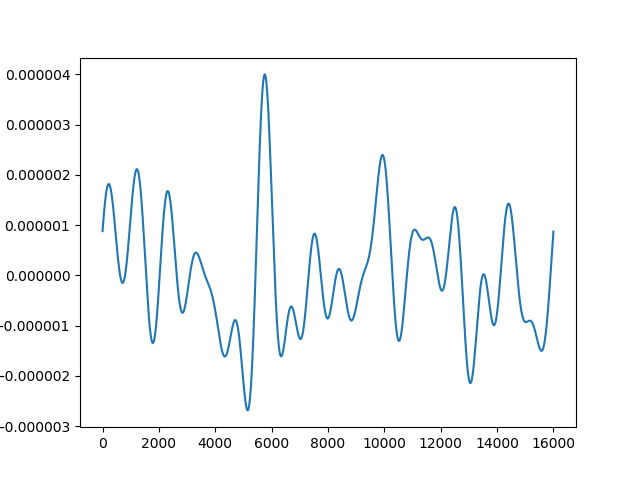

6.6873974619e-06
16000


In [466]:
plt.figure()
plt.plot(dispath)
print np.amax(dispath)-np.amin(dispath)
print len(dispath)

In [467]:
slope = np.max(np.abs(np.gradient(dispath)))
m = 1.1*slope/(dens*200)
print m
def GeoPath(center):
    gp = m*(np.arange(-dens*100,+dens*100+1)-center)**2
    return gp

2.44929852614e-11


<IPython.core.display.Javascript object>


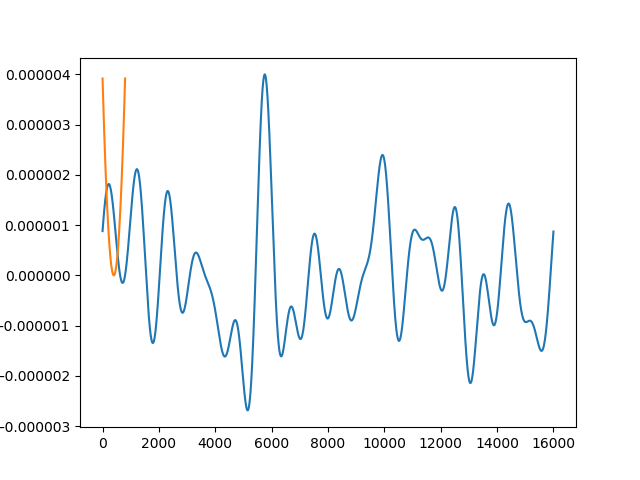

In [468]:
plt.figure()
plt.plot(dispath)
plt.plot(GeoPath(0))

In [469]:
def GeoPath2(center):
    gp = 1/(2*R) * ((np.arange(-dens*500,+dens*500+1)-center) * intime *358e3/3e8 )**2
    return gp

<IPython.core.display.Javascript object>


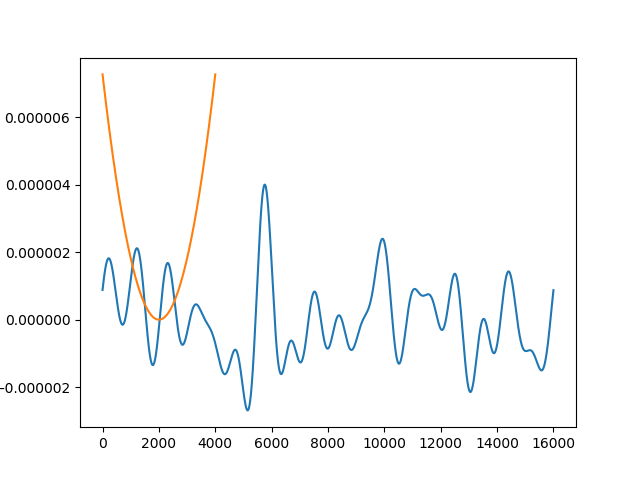

4001


In [470]:
geopath = GeoPath2(0)
plt.figure()
plt.plot(dispath)
plt.plot(geopath)
print len(geopath)
#plt.ylim(-4e-6,4e-6)

<IPython.core.display.Javascript object>


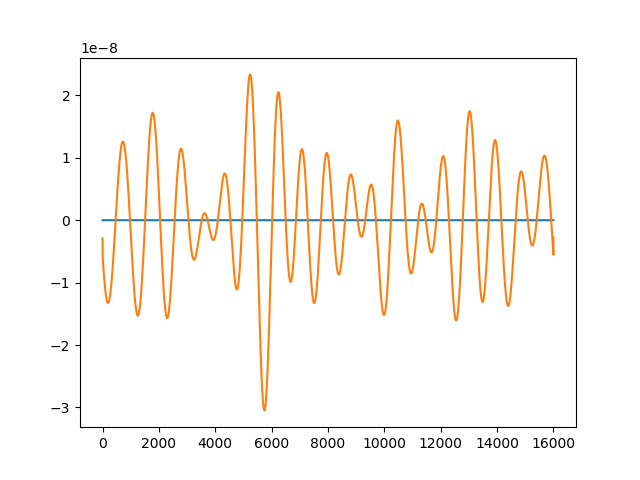

In [471]:
plt.figure()
plt.plot(np.arange(len(dispath)),np.ones(len(dispath))*np.amax(np.gradient(np.gradient(geopath))))
plt.plot(np.gradient(np.gradient(dispath*311.25)))

7895


<IPython.core.display.Javascript object>


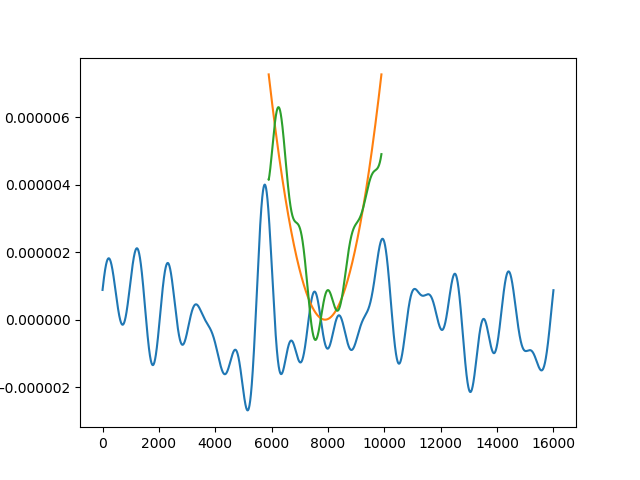

In [472]:
center = 7895
print center
totpath = geopath-np.pad(dispath[int(center-(len(geopath)-1)/2):int(center+(len(geopath)-1)/2+1)],1,'edge')[:len(geopath)]

plt.figure()
plt.plot(dispath)
plt.plot(np.arange(center-(len(geopath)-1)/2,center+(len(geopath)-1)/2+1),geopath)
plt.plot(np.arange(center-(len(geopath)-1)/2,center+(len(geopath)-1)/2+1),totpath)

In [473]:
np.save('data/test_physical_Dis.npy',dispath)